In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
# import string
# from string import punctuation
# from itertools import chain

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_selection import SelectPercentile, chi2, f_regression, f_classif
from sklearn.utils import shuffle

! pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
# from sklearn import svm

# nltk.download('stopwords')
# from nltk.stem import WordNetLemmatizer
# from nltk import ngrams

import re
import string

! pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


! pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

! pip install tensorflow

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
import io
import json

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kaila\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaila\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [55]:
analysis_set = pd.read_csv("csv's/AnalysisDataset.csv")

In [56]:
reviews = analysis_set["cleanedText"]
reviews = reviews.apply(lambda x: re.sub(r"\s+", " ", str(x)).strip() if isinstance(x, (str, float, int)) else x)

In [57]:
unseen_reviews = []
for review in reviews:
    unseen_reviews.append(review)

In [58]:
unseen_reviews

['really like ear swab first come large handy box easy store last long time second organic good environment third strong fall apart easily highly recommend used year',
 'honest rarely used overnight cream typically skin care routine morning night wash apply hyalauronic serum kind moistutrizer saw iryasa cream wanted try easy apply immediately feel moisture starting work apply minute actually go sleep allow time absorbed putting face pillow thicker type cream need time skin morning feel better ever soft supple definitely feel difference using week highly recommend cream woman men',
 'purchased see could set mom hair fine thin short hair think could fun fluffy set mom super old school hoping little foam styling product',
 'great multi pack band great price wash well laundry lose elasticity',
 'easy use',
 'good way use face oil normally skip facial oil like way feel face one mixed cream leave face feeling greasy oily applying pleasant scent sticky though leave behind little tackiness dis

In [59]:
with open('embedded.json') as f:
    data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(data)

In [60]:
unseen_tokenized = loaded_tokenizer.texts_to_sequences(unseen_reviews)
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=100)

In [61]:
from keras.models import load_model

model_path = 'lstm_model.keras'
pretrained_lstm_model = load_model(model_path)
pretrained_lstm_model.summary()
preds = pd.Series()
preds = pretrained_lstm_model.predict(unseen_padded)
# unseen_sentiments

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     6,029,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,381,833 (24.34 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 6,029,700 (23.00 MB)

 Optimizer params: 234,756 (917.02 KB)

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step


In [62]:
analysis_set["predictedRating"] = np.round(preds * 5, 1)
analysis_set.head(1)

,Unnamed: 0,category,item,rating,cleanedText,timestamp,numRating,average_rating,total_votes,sentiment,popularity_score,predictedRating
0,1,All Beauty,Organic Bamboo Cotton Ear Swabs by Bali Boo - ...,5.0,really like ear swab first come large handy bo...,2020-08-03 16:49:11.088,49.0,4.2,0,1.0,30.66,5.0


In [63]:
analysis_set.to_csv("csv's/Predictions.csv")

In [221]:
df = pd.DataFrame()
df = pd.read_csv("csv's/Predictions.csv")

In [222]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['month']= df['timestamp'].dt.month

# Grouped months by their mean popularity scores

In [223]:
popularity_by_month = df.groupby(['category', 'month'])['popularity_score'].mean().div(1000).round(2).reset_index()

In [ ]:
def get_top_categories_by_month(month_num):
    # Filter for the specific month
    month_data = popularity_by_month[popularity_by_month['month'] == month_num]
    
    # Sort by popularity_score in descending order and take top 5
    top_categories = month_data.sort_values('popularity_score', ascending=False).head(3)
    
    return top_categories

In [225]:
top_categories_by_month = {}
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
              'July', 'August', 'September', 'October', 'November', 'December']

In [226]:
for i in range(1, 13):
    top_categories = get_top_categories_by_month(i)
    top_categories_by_month[month_names[i-1]] = top_categories

In [227]:
result_df = pd.DataFrame()

for month_name, top_data in top_categories_by_month.items():
    if not top_data.empty:
        # Add month name as a column
        top_data_with_month = top_data.copy()
        top_data_with_month['month_name'] = month_name
        
        # Append to result DataFrame
        result_df = pd.concat([result_df, top_data_with_month])

In [228]:
final_result = result_df[['month', 'month_name', 'category', 'popularity_score']].sort_values(
    by=['month', 'popularity_score'], 
    ascending=[True, False]
)

In [230]:
final_result

,month,month_name,category,popularity_score
186,1,January,Gift Cards,41.73
143,1,January,Camera & Photo,18.38
329,1,January,Prime Video,16.88
36,1,January,Amazon Devices,13.71
198,1,January,Grocery,9.25
37,2,February,Amazon Devices,55.95
187,2,February,Gift Cards,39.49
132,2,February,Buy a Kindle,24.03
305,2,February,Pet Supplies,8.88
199,2,February,Grocery,8.23


# Grouped months by number of reviews

In [173]:
df['month']= df['timestamp'].dt.month
df.head(1)

,Unnamed: 0.1,Unnamed: 0,category,item,rating,cleanedText,timestamp,numRating,average_rating,total_votes,sentiment,popularity_score,predictedRating,month
0,0,1,All Beauty,Organic Bamboo Cotton Ear Swabs by Bali Boo - ...,5.0,really like ear swab first come large handy bo...,2020-08-03 16:49:11.088,49.0,4.2,0,1.0,30.66,5.0,8


In [174]:
groupMonth= df.groupby(['category', 'month']).size().reset_index(name= 'count')
groupMonth.head(1)

,category,month,count
0,AMAZON FASHION,1,88


In [175]:
groupMonth= groupMonth.pivot(index= 'category', columns= 'month', values= 'count').fillna(0)
groupMonth.head(1)

month,1,2,3,4,5,6,7,8,9,10,11,12
category,,,,,,,,,,,,
AMAZON FASHION,88.0,57.0,83.0,79.0,70.0,63.0,64.0,60.0,59.0,75.0,54.0,69.0


In [176]:
months= range(1, 13) #1 -> 12
month_names= ['January', 'February', 'March', 'April', 'May', 'June', 
              'July', 'August', 'September', 'October', 'November', 'December']

groupMonth= groupMonth.reindex(columns= months, fill_value= 0) #reindexs in case a column doesnt exist
groupMonth.columns= month_names
groupMonth.head(1)

,January,February,March,April,May,June,July,August,September,October,November,December
category,,,,,,,,,,,,
AMAZON FASHION,88.0,57.0,83.0,79.0,70.0,63.0,64.0,60.0,59.0,75.0,54.0,69.0


In [177]:
groupMonth= groupMonth.reset_index()
groupMonth = groupMonth.astype({month: int for month in month_names})
groupMonth

,category,January,February,March,April,May,June,July,August,September,October,November,December
0,AMAZON FASHION,88,57,83,79,70,63,64,60,59,75,54,69
1,All Beauty,115,95,115,100,110,105,92,116,82,83,88,107
2,All Electronics,42,29,17,16,15,21,18,11,22,16,17,32
3,Amazon Devices,4,1,0,3,1,2,3,3,1,0,2,3
4,Amazon Home,191,137,146,148,142,143,163,135,108,153,146,151
5,Apple Products,0,2,0,1,0,0,0,0,0,0,0,0
6,Appliances,37,26,37,25,25,30,34,27,32,29,25,45
7,Appstore for Android,81,55,57,55,57,67,63,62,69,67,38,60
8,"Arts, Crafts & Sewing",10,16,10,12,13,7,10,18,18,9,15,9
9,Automotive,13,12,8,6,14,8,8,10,10,10,11,9


Top 5 Categories by Popularity Score for Each Month:
    Month  Rank                  Category  Popularity Score
  January     1                Gift Cards             41.73
  January     2            Camera & Photo             18.38
  January     3               Prime Video             16.88
  January     4            Amazon Devices             13.71
  January     5                   Grocery              9.25
 February     1            Amazon Devices             55.95
 February     2                Gift Cards             39.49
 February     3              Buy a Kindle             24.03
 February     4              Pet Supplies              8.88
 February     5                   Grocery              8.23
    March     1                Gift Cards             29.38
    March     2      Appstore for Android              8.64
    March     3               Prime Video              8.44
    March     4                   Grocery              7.27
    March     5              Pet Supplies      

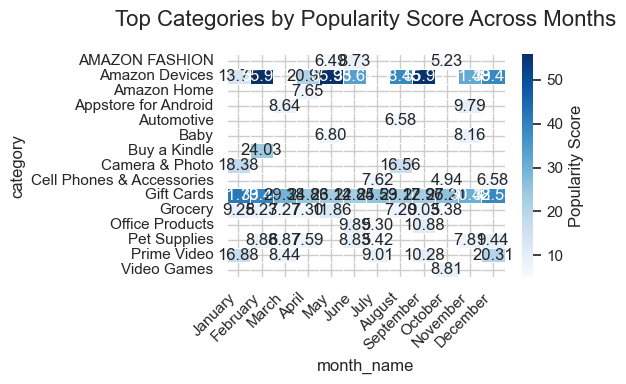

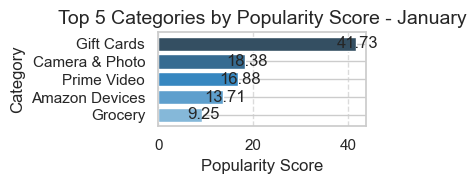

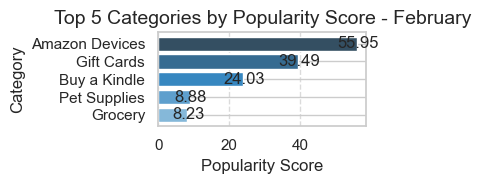

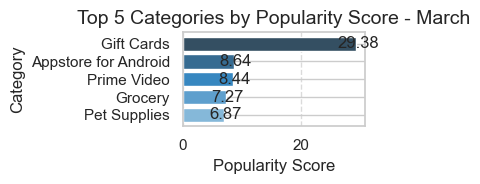

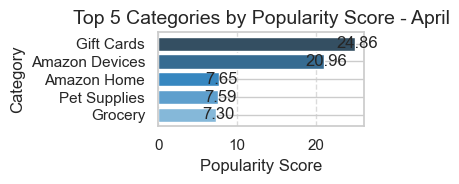

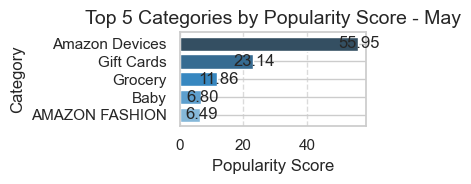

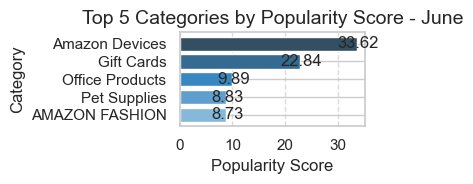

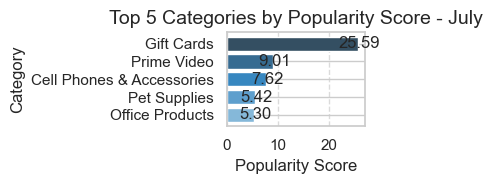

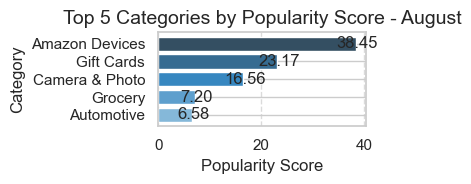

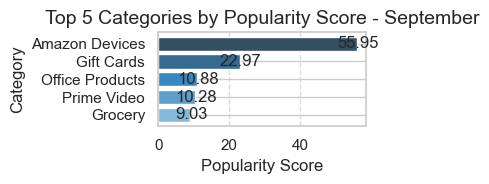

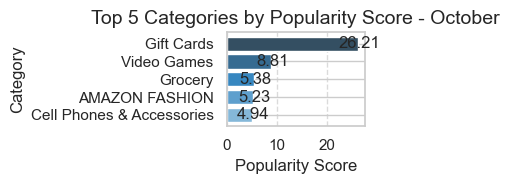

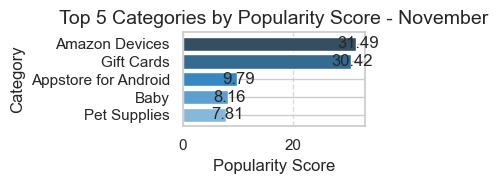

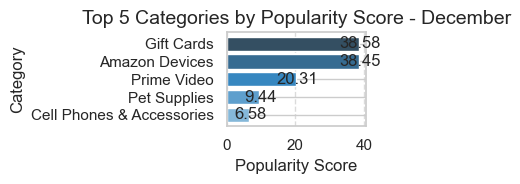

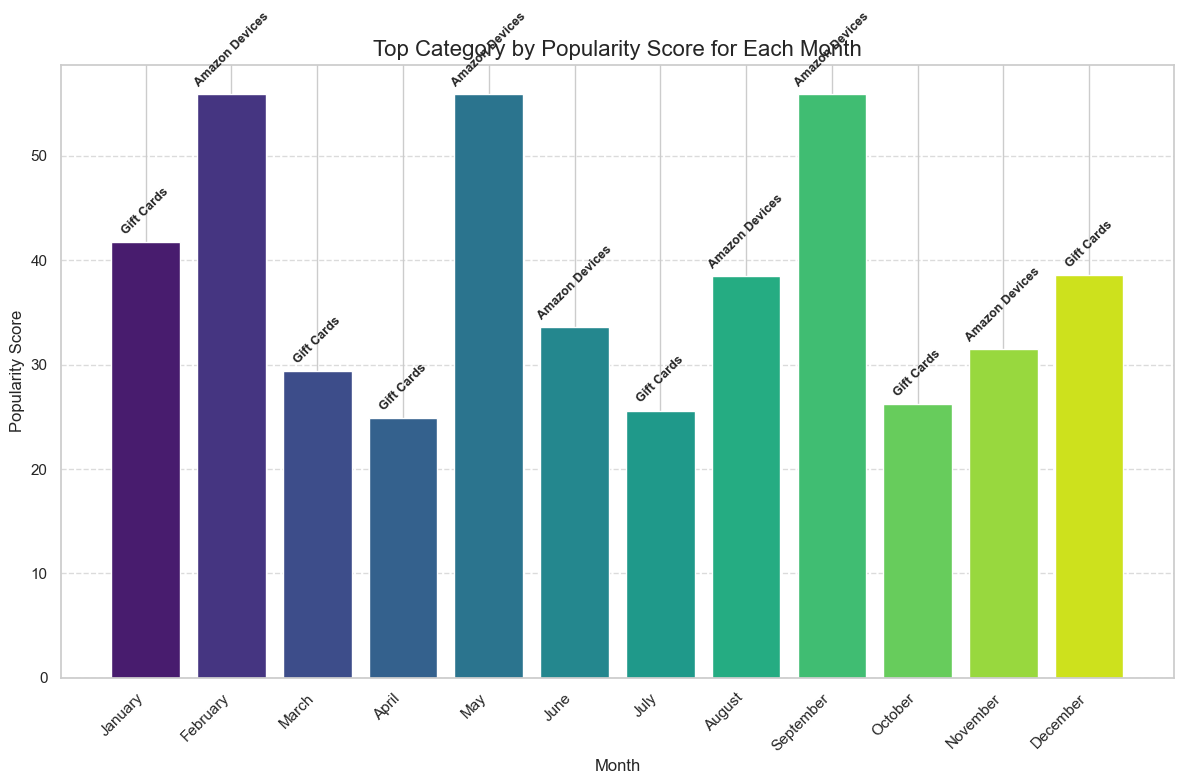

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import calendar

# Assuming df is your original dataframe with all the data
# First, make sure we're working with the correct month format
df['month'] = pd.to_datetime(df['timestamp']).dt.month

# Group by category and month, calculating average popularity_score
popularity_by_month = df.groupby(['category', 'month'])['popularity_score'].mean().div(1000).round(2).reset_index()

# Month names for reference
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
              'July', 'August', 'September', 'October', 'November', 'December']

# Create a dictionary to map month numbers to names
month_map = {i+1: name for i, name in enumerate(month_names)}

# Add month names to the popularity dataframe
popularity_by_month['month_name'] = popularity_by_month['month'].map(month_map)

# Create a list to store DataFrames for each month
monthly_top_dfs = []

# Get top 5 categories for each month and format them nicely
for month_num in range(1, 13):
    # Filter for specific month
    month_data = popularity_by_month[popularity_by_month['month'] == month_num]
    
    if not month_data.empty:
        # Sort by popularity_score and get top 5
        top_categories = month_data.sort_values('popularity_score', ascending=False).head(5)
        
        # Add ranking column
        top_categories['rank'] = range(1, len(top_categories) + 1)
        
        # Add month name
        top_categories['month_name'] = month_map[month_num]
        
        monthly_top_dfs.append(top_categories)

# Combine all monthly data
if monthly_top_dfs:
    all_top_categories = pd.concat(monthly_top_dfs)
    
    # Format the popularity_score to 2 decimal places
    all_top_categories['popularity_score'] = all_top_categories['popularity_score'].round(2)
    
    # Create a pivot table for heatmap visualization
    pivot_data = all_top_categories.pivot_table(
        index='category', 
        columns='month_name',
        values='popularity_score',
        aggfunc='first'
    )
    
    # Reorder columns by month
    pivot_data = pivot_data.reindex(columns=month_names)
    
    # Create a nicer table view
    styled_table = all_top_categories.pivot_table(
        index=['month_name', 'rank'], 
        columns=[], 
        values=['category', 'popularity_score'],
        aggfunc='first'
    ).reset_index()
    
    # Sort by month number and rank
    month_to_num = {name: i for i, name in enumerate(month_names, 1)}
    styled_table['month_num'] = styled_table['month_name'].map(month_to_num)
    styled_table = styled_table.sort_values(['month_num', 'rank'])
    styled_table = styled_table.drop('month_num', axis=1)
    
    # Rename columns for better readability
    styled_table.columns = ['Month', 'Rank', 'Category', 'Popularity Score']
    
    # Show the styled table
    print("Top 5 Categories by Popularity Score for Each Month:")
    print(styled_table.to_string(index=False))
    
    # VISUALIZATIONS
    
    # 1. Create a heatmap of top categories across months
    plt.figure(figsize=(15, 10))
    
    # Create a custom colormap from white to deep blue
    colors = ["#f7fbff", "#deebf7", "#c6dbef", "#9ecae1", "#6baed6", "#4292c6", "#2171b5", "#08519c", "#08306b"]
    cmap = LinearSegmentedColormap.from_list("blue_gradient", colors)
    
    # Plot the heatmap
    ax = sns.heatmap(pivot_data, cmap=cmap, annot=True, fmt='.2f', linewidths=.5, 
                 cbar_kws={'label': 'Popularity Score'})
    
    plt.title('Top Categories by Popularity Score Across Months', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('category_popularity_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Create a bar chart for each month showing top 5 categories
    for month_num in range(1, 13):
        month_name = month_map[month_num]
        month_data = all_top_categories[all_top_categories['month'] == month_num]
        
        if not month_data.empty:
            plt.figure(figsize=(10, 6))
            
            # Sort by popularity score
            month_data = month_data.sort_values('popularity_score', ascending=True)
            
            # Create horizontal bar chart with a nice color palette
            bars = plt.barh(month_data['category'], month_data['popularity_score'], 
                     color=sns.color_palette("Blues_d", len(month_data)))
            
            # Add data labels to the end of each bar
            for bar in bars:
                width = bar.get_width()
                plt.text(width + 0.3, bar.get_y() + bar.get_height()/2, 
                        f'{width:.2f}', ha='center', va='center')
            
            plt.xlabel('Popularity Score')
            plt.ylabel('Category')
            plt.title(f'Top 5 Categories by Popularity Score - {month_name}', fontsize=14)
            plt.grid(axis='x', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.savefig(f'top_categories_{month_name}.png', dpi=300, bbox_inches='tight')
            plt.show()
    
    # 3. Create a single combined bar chart showing top category for each month
    plt.figure(figsize=(12, 8))
    
    # Get the top category for each month
    top_by_month = all_top_categories.loc[all_top_categories.groupby('month')['popularity_score'].idxmax()]
    
    # Sort by month
    top_by_month = top_by_month.sort_values('month')
    
    # Plot
    bars = plt.bar(top_by_month['month_name'], top_by_month['popularity_score'], 
            color=sns.color_palette("viridis", len(top_by_month)))
    
    # Add category labels above each bar
    for i, (bar, category) in enumerate(zip(bars, top_by_month['category'])):
        plt.text(i, bar.get_height() + 0.5, category, ha='center', va='bottom', rotation=45, 
                fontweight='bold', fontsize=9)
    
    plt.xlabel('Month')
    plt.ylabel('Popularity Score')
    plt.title('Top Category by Popularity Score for Each Month', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('top_category_by_month.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No data found for any month.")